# Predictions of fraudlent users in a Bitcoin user network #

On platforms where users interact with each other to perform some type of financial transaction, it is very desirable to stop users who act in a fraudulent manner from being able to access or continue to use the platform. However, investigating users can be very expensive (consider e.g sellers on Ebay or Amazon) or impossible (consider users on a Bitcoin network) depending on the context. It is therefore worth asking the following - is it possible to perform accurate inference for the trustworthiness of users simply based on their behavior on the platform? We investigate this using publically available data for a Bitcoin user platform, where we observe ratings between users (and the times at which these ratings are made), and only know for a small subset of users whether they are trustworthy or not. 

## Summary of data ## 

For the dataset we are considering, we have 5,881 nodes (corresponding to separate users) and 35,592 weighted edges (corresponding to ratings from one user to another), along with time-stamp data; for example, a subset of the data looks like the following:

Source node | Target node | Rating | Time stamp
:----------:|:-----------:|:------:|:---------:
6 | 2 |	4 | 1289241912
6 | 5 | 2 | 1289241942
1 | 15 | 1 | 1289243140
4 | 3 | 7 | 1289245277
13 | 16 | 8 | 1289254254
13 | 10 | 8 | 1289254301
7 | 5 | 1 | 1289362700
2 | 21 | 5 | 1289370557

We note that ratings are integer valued between -10 to 10 (going from not-trustworthy to trustworthy) - when we analyse the data, we will normalize these to lie in \[0, 1\], and we will ignore the fact that user ratings are given on an integer scale. This is done mostly for computational reasons - it will be easier to try and infer a likelihood/probability of trustworthiness using variational inference or MCMC methods than trying to perform inference for the discrete latent state. If we were really interested in performing inference for the underlying latent state, then we could simply do so by thresholding these probabilities at a later state. The measurements for the time stamps are given as measurements of the time in seconds after 'Epoch' (January 1st 1970) in which the ratings were made; although we could try and use this information more substanatially (and e.g try and model trustworthiness as a function of time), for now we will only use it to compute per-node summary statistics. 

We also have some notion of "ground truth" data for the users in the network - there are 136 users which are considered trustworthy, and 180 (so we have ground truth data for 316 users in total). Note that this is only for a subset of the users, so we will use a semi-supervised approach to modelling our data. As our end goal is to make inference for the trustworthiness for users, we will split the ground truth data in the following way:

* We randomly select 200 user ratings to use as a training set;
* We keep the remaining 116 to use as a test set.

Why split the ground truth data? Note that we only have partial information as to whether users are trustworthy, yet our overall goal is to infer some statistic of trustworthiness for **every** user. We therefore keep some of our ground truth data to the side so we can use it to ensure that our models are correctly calibrated when trying to make inference for the user trustworthiness. One last note: there is likely an imblance in the proportions of trustworthy/non-trustworthy users in the train/test sets, as compared to those in the whole population, and so this is something which we should be aware of when modelling our data.

## A quick caveat on our notion of ground truth ## 
Given that our data is taken from an inherently anonymous platform, you may (rightfully) ask whether the notion of 'ground-truth trustworthiness' comes from. For this dataset, the platform founder and those who they rated highly are considered to be trustworthy, and the users rated very lowly by the latter group are considered to be un-trustworthy. (In terms of the numerical specifics, I'm afraid I don't have those at hand - it's not very clear from the data source what exactly was done to obtain this information.) As a result, this is a clear limitation as to whether these users are actually acting fraudulently or not - instead we are really making inference for whether the platform holder would consider someone to be trustworthy. From e.g the perspective of the platform founder, this probably would suffice. 

# Exploratory data analysis

Before beginning to model the data in order to try and make inference for the trustworthiness of different users, we begin by exploring some of the features of our dataset to see what could potentially be informative for the purposes of achieving our overall goal. In particular, we're going to examine the following statistics of the data:

* The in and out degree distribution (i.e, how many ratings a user has received and given respectfully)
* The distribution of the mean and average ratings recived and given by users 
* The standard deviation of the time at which ratings are made
* Rating asymmetry - the difference between the in and out degrees of a node, and simiarly the difference of the average in rating and out rating

For the users whose ground truth state is available, we'll highlight their distribution in blue and orange (corresponding to trustworthy and not-trustworthy respectfully), and otherwise keep the overall distribution in grey. Rather than plot histograms, we plot various kernel density estimates, which have been constrained to lie within most of the support for the empirical distribution of each statistic. (Note that some of the constraints are natural - e.g the average rating lies within [0, 1], the standard deviations are non-negative; we trim some of the large values for e.g the number of ratings given/received to keep the graphs readable. As we are mostly using the graphs for qualitative purposes to begin forming a model, this will not lead to us making erronous deductions from the data.)

In [1]:
import torch
from bitcoin import BitcoinOTC

# Converting torch tensors to numpy arrays...
data = BitcoinOTC()
out_degree = data.out_degree.numpy()
in_degree = data.in_degree.numpy()
out_weight_avg = data.out_weight_avg.numpy()
out_weight_std = data.out_weight_std.numpy()
in_weight_avg = data.in_weight_avg.numpy()
in_weight_std = data.in_weight_std.numpy()
rate_time_out_std = data.rate_time_out_std.numpy()
rate_time_in_std = data.rate_time_in_std.numpy()
gt = data.gt.numpy()

c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\andrew\anaconda3\envs\ppp\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


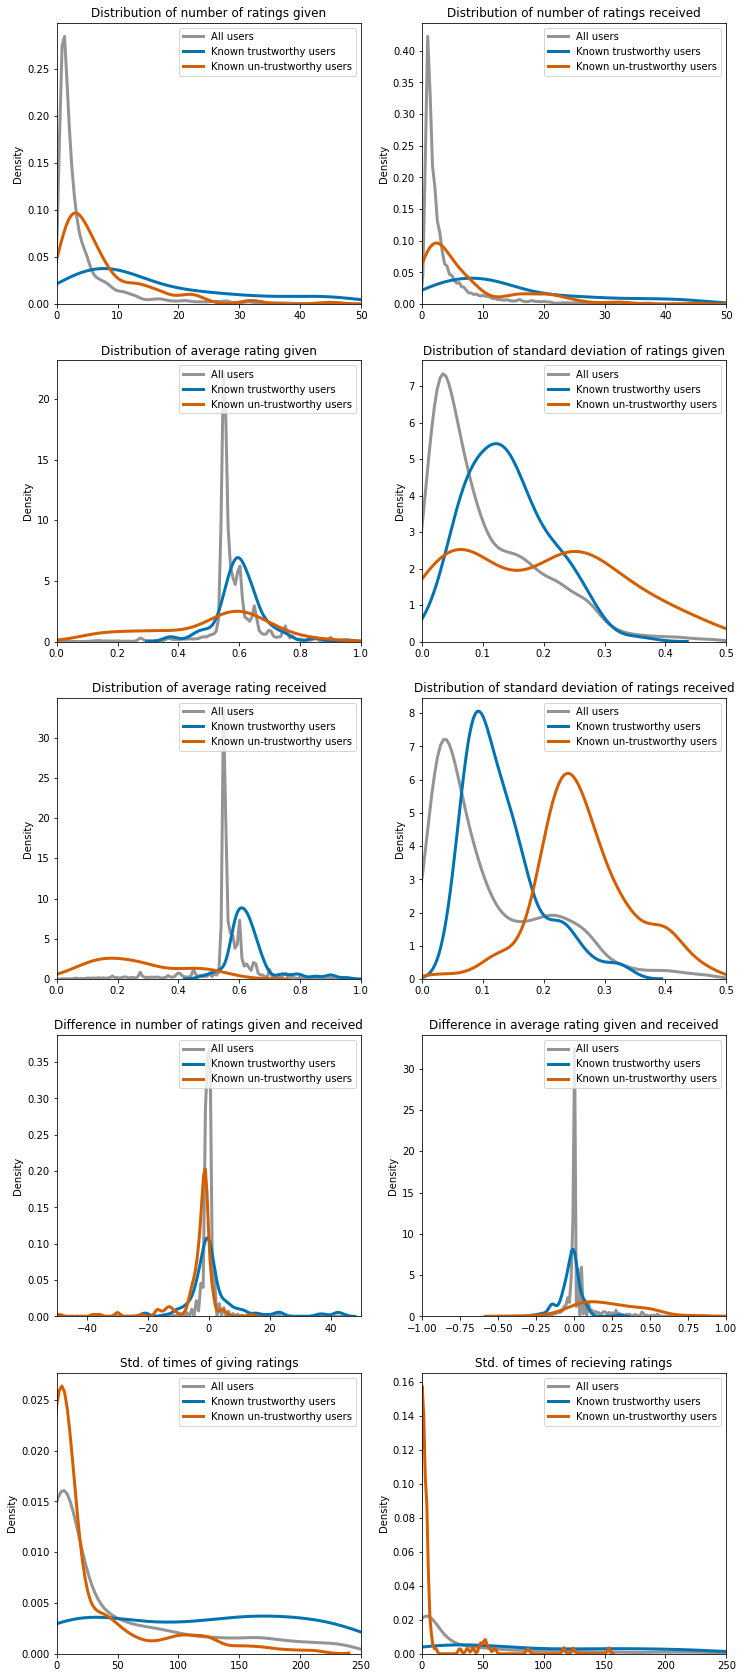

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define colour/labels, axis limits to use for the plots
colors = ['#949494', '#0173B2', '#D55E00']
labels = ['All users', 'Known trustworthy users', 'Known un-trustworthy users']
title_label = ['Distribution of number of ratings given',
               'Distribution of number of ratings received',
               'Distribution of average rating given',
               'Distribution of standard deviation of ratings given',
               'Distribution of average rating received',
               'Distribution of standard deviation of ratings received',
               'Difference in number of ratings given and received',
               'Difference in average rating given and received',
               'Std. of times of giving ratings',
               'Std. of times of recieving ratings']
xlim_list = [[0, 50], [0, 50], [0, 1], [0, np.sqrt(0.25)], [0, 1], [0, np.sqrt(0.25)],
             [-50, 50], [-1, 1], [0, 250], [0, 250]]

# Define data, relevant masks
stats = [out_degree, in_degree, out_weight_avg, out_weight_std, in_weight_avg, in_weight_std, 
         out_degree - in_degree, out_weight_avg - in_weight_avg, 
         rate_time_out_std, rate_time_in_std]
masks = [range(data.num_nodes), (gt == 1), (gt == 0)]

# Begin plotting
f = plt.figure(figsize=(12, 30))

for i, stat in enumerate(stats):
    ax = f.add_subplot(5, 2, i+1)
    
    for j, mask in enumerate(masks):
        temp_data = stat[mask]
        temp_data = temp_data[~np.isnan(temp_data)]
        
        sns.distplot(temp_data, 
                     hist = False, 
                     kde = True,
                     kde_kws = {'linewidth': 3, 'clip': xlim_list[i]},
                     label = labels[j],
                     color = colors[j],
                     ax = ax)
    
    ax.set_title(title_label[i])
    ax.set_ylabel('Density')
    ax.set_xlim(xlim_list[i])
    ax.legend(loc='upper right')

plt.show()

Examining the above plots, we see that in terms of node-level information we can use to try and predict whether a user is trustworthy, we observe that there are a few discriminating features we could try and use:

* **The average rating received** - Somewhat unsuprisingly, the average rating received by untrustworthy users is lower than that of trustworthy users, and lies on the left tail of the overall distribution of average ratings. 
* **The standard deviation of ratings given and received** - As observable from the two graphs, large observed values of the standard deviation of the ratings given or received by a user are more likely to come from users who have been deemed non-trustworthy, compared to both the base population and users who are considered trustworthy. For the ratings received, this is not too unsuprising - one can imagine that a collection of conspiring users who are not trustworthy will try and collectively give each other large positive ratings, while other users will give them large negative ratings. However, it is a bit more difficult to try and think of a reason as to why the standard deviation of the ratings given seems to vary across the different population.
* **Standard deviation of rating times** - This appears to be a somewhat weaker form of evidence, but we note that a large proportion of un-trustworthy users are only active for a short period of time, whereas the distribution of trustworthy is more uniform (and similarly so for the overall population of users).

Given this, we'll therefore begin by looking at the level of performance given by a simple Bayesian logistic regression model using the above variables as covariates, and see what level of performance this gives us in terms of false positives/negatives. While we do not expect this to be brilliant, this gives us a simple baseline to work with when we want to start evaluating the performance of more 'fancy' methods.

# Model 1: A straightforward Bayesian logistic regression



# Stochastic Black Box Variational Inference for Network Data

Recall that in variational inference, the goal is to approximate a desired posterior distribution $p(\mathbf{z} | \mathbf{x})$ of some latent variables $\mathbf{z}$ given our data $\mathbf{x}$ using a variational family $q(\mathbf{z} | \lambda)$, with $\lambda$ parameterizing our variational family. To try and do so in an automated fashion, we update $\lambda$ via performing gradient ascent on the ELBO, whose gradient is 

$$ \nabla_{\lambda} \mathrm{ELBO} = \mathbb{E}_{\mathbf{z} \sim q(\cdot|\lambda) }\Big[ \nabla_{\lambda} \log q(\mathbf{z} | \lambda) \big\{ \log p(\mathbf{x}, \mathbf{z}) - \log q(\mathbf{z} | \lambda) \big\} \Big]   $$

In practice, we then usually make use of the two following ideas in order to perform computationally efficient inference:

* **Approximating the expectation** - We draw samples from $\mathbf{z} \sim q(\cdot | \lambda)$ to give a Monte Carlo estimate of the above expectation;
* **Approximating the log-likelihood** - To illustrate through an example, suppose we are in a regime where the likelihood for the data factors as $p(\mathbf{x} | \mathbf{z}) = \prod_{i=1}^N p(x_i | z_i)$ - i.e we have $N$ data points $x_i$ which are conditionally independent given local latent variables $z_i$. If our number of data points $N$ is large, rather than compute $\sum_{i=1}^N \log p(x_i | z_i) + \log(z_i)$, we instead draw a subset $I_M$ of $M$ data points and instead use the approximation
$$ \sum_{i=1}^N \big\{ \log p(x_i | z_i) + \log(z_i) \big\} \approx \frac{N}{M} \sum_{i \in I_M} \big\{ \log p(x_i | z_i) + \log(z_i) \big\}. $$
This works well in practice even when $M \ll N$, i.e when the number of subsampled data points is far smaller than the total number. 

Focusing on the latter idea for now, this approach of subsampling data points is very intuitive for when we are fitting data which either naturally arises as being conditionally independent (such as for data we may consider modelling through a traditional regression), or we can extract some statistics from our data which can then be modelled in the same way (consider for example a topic model given a set of documents, where all we use are counts of words from a group of documents). 

However, for certain types of structured data, some care and thought is required in trying to exploit ideas of subsampling to approximate the log-likelihood. Suppose we observe a undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ where the number of nodes $|\mathcal{V}| = N$, and $\mathcal{E}$ is the list of edges; we can also equivalently think of having observed an adjacency matrix $A = (a_{ij})_{i, j \in \mathcal{V}}$. Some real-world examples of data collected in this format include:

* **Social networks** - Here, users of the social network correspond to the vertices, and edges correspond to whether they are e.g friends on the network. You can imagine that we also have nodal information corresponding to characteristics of each user; for example, age, gender, geographical location, hobbies/interests and et cetera.
* **Protein-protein interaction networks** - In these networks, we look at different proteins within a particular type of cell, and form a network with proteins as vertices, and edges denoting whether two proteins contribute to a shared biological function.
* **User-trust networks** - Here, users correspond to vertices, with an edge from one vertex to the other corresponding to a user providing a rating, the edge label corresponding to a rating of trust one user gave to another.

In the first two examples, we note that the presence of the edge between two vertices should be more likely if the two vertices have comparable latent features, and in the latter the distribution of the edge labels (that is, the ratings between users) should be different if a non-fraudlant user is rating a fruadlant user, as compared to a fraudlant user rating rating another fraudlant user. To summarize, for network data, while we care about making latent observations about each observed vertex, we need to do so using some amount of edge information. 

For such a network (supposing for now it is directed and without self-loops), we could imagine trying to form a Bayesian model of the form  

$$ \begin{aligned}
p(\omega_1, \ldots, \omega_N) &= \prod_{i=1}^N N(\omega_i \,|\, 0, \eta^2 I_d) \\
p(\{ a_{ij} \,|\, i \neq j \} \,|\, \omega_1, \ldots, \omega_n) &= \prod_{i \neq j} \mathrm{Bernoulli}\big(a_{ij} \,\big|\, \sigma(\langle \omega_i, \omega_j \rangle) \big)
\end{aligned}$$

where $\eta^2$ is specified in advance, and $\sigma(x) = e^x/(1+e^x)$ is the logistic function. We can then write the log-likelihood down as 

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) = \sum_{i \neq j} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \sum_{i=1}^n \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

If we now let $S(\mathcal{G}) = (\mathcal{V}', \mathcal{E}')$ denoted a "subsampled" version of the network, where $\mathcal{V}' \subseteq \mathcal{V}$ and $\mathcal{E}'$ is a list of pairs of vertices $\mathcal{E}'$ (note that this may necessarily not be a subset of $\mathcal{E}$ of our original edge set), we could approximate the log-likelihood by 

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) \approx \frac{ N(N-1)  }{ |\mathcal{E}'| } \sum_{(i, j) \in \mathcal{E}'} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \frac{ N }{ |\mathcal{V}'|   } \sum_{i \in \mathcal{V}'} \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

We now need to address the question of how we choose $S(\mathcal{G})$. Although there are some obvious first examples (e.g sample edges randomly), the work of Grover and Leskovec introduced "node2vec" [1], which uses biased random walks to help form $S(\mathcal{G})$. Later work by Vietch et al. [2] highlights that the **choice of sampling scheme is a modelling decision**, with some on-going work (D. and Austern, [3]) making explicit how changing the sampling scheme effects the latent structure recovered (under the assumption that the graph is exchangable). The important take-away from this is as follows:

> **For the purposes of Box's loop, we should take into account our choice of sampling scheme as part of our modeling step, moreso than as part of our inference step.**

One final remark: so far we've been talking implicitly about using variational inference to approximate the posterior distribution. Beyond the inability to use subsampling methods for MCMC methods to obtain samples from the posterior, there is one other thing to note: given the form of the likelihood and prior on the $\omega_i$ and $a_{ij}$ as above, the posterior will be _rotationally invariant_; that is, if $Q \in \mathbb{R}^{d \times d}$ is an orthogonal matrix, then 

$$ Q\omega_1, \ldots, Q \omega_N | a_{ij}, i \neq j \stackrel{\text{d}}{=} \omega_1, \ldots, \omega_N | a_{ij}, i \neq j. $$

As a consequence, the posterior mean (for example) of the $\omega_i$ will be equal to zero, and so extracting sensible summary statistics from our learned embeddings will be far more difficult. (For those familar with MCMC methods, this can be thought of as being due to a lack of identifiability of the $\omega_i$ in the above model, and so infact we would expect to have other computational difficulties in trying to sample from the posterior.) 

# References

[1] - 

[2] - 

[3] - 